# Text Clustering with K-Means
In the present notebook we will use the [k-means algorithm](https://www.datascience.com/blog/k-means-clustering), a simple and popular __*unsupervised clustering*__ algorithm, to cluster the national anthems of the world into different groups.

The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed defined number (k) of centroids in a dataset. A centroid refers to a cluster, which is a collection of data points aggregated together because of certain similarities with each other. The ‘means’ in the K-means refers to the averaging of the data; that is, finding the centroid. And the algorithm is said to be unsupervised because we have no prior knowledge with regards to the groups or classes of our dataset, that is, we will find the underlying groups in our dataset!

Below we can visualize the algorithm. The green centroids matches the closest datapoints to each one and form clusters, then each centroid moves to the center of each respective group and matches again the closest datapoint to each other.

![alt text](Images/kmeans.gif "Title")

**Steps:**

__1.__ Explore our collection of international music (corpus) <br>
__2.__ Data Engineer the dataset to get the best perfomance from the K-means algorithm <br>
__3.__ Run the algorithm many times, each time testing with a different number of clusters <br>
__4.__ Use different metrics to visualize our results and find the best number of clusters (*ie. Why are a total of X clusters better than a total of Y clusters*) <br>
__5.__ Cluster Analysis

**Metrics Utilized for Determining the Best Number of K Cluters:**
- [Elbow Method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

## Importing Libraries:

In [1]:
# Data Structures
import numpy  as np
import pandas as pd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fardi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fardi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Corpus Loading:

We'll use pandas to read the csv file contaning the national anthem for each country and it's corresponding country code. The anthems were extracted from wikipedia and many of them contain words that use non UTF-8 characters (generaly names of places and such), so we'll read the file with the _latin1_ encoding.

Then we'll extract the __Song__ column into a list of texts for our corpus.

In [2]:
data = pd.read_csv('datasets/lyrics.csv')
data.columns = map(str.lower, data.columns)

#continents = ['Europe', 'South_America', 'North_America']
#data = data.loc[data['continent'].isin(continents)]
data.head(10)

,unnamed: 0,link,artist,song_name,lyrics
0,0,../lyrics/backstreetboys/climbingthewalls.html,Backstreet Boys Lyrics,Climbing The Walls,"\n\n[Brian:]\nClose your eyes, make a wish\nTh..."
1,1,../lyrics/westlife/howtobreakaheart.html,Westlife Lyrics,How To Break A Heart,\n\r\nSince you're not worth my love\nI haven'...
2,2,../lyrics/deanmartin/iwill.html,Dean Martin Lyrics,I Will,\n\r\nI don't want to be the one to say I'm go...
3,3,../lyrics/deanmartin/tellyourmotherhello.html,Dean Martin Lyrics,Tell Your Mother Hello,\n\r\nSure I loved the dear money that shines ...
4,4,../lyrics/deanmartin/behonestwithme.html,Dean Martin Lyrics,Be Honest With Me,\n\r\nBe honest with me dear whatever you do\n...
5,5,../lyrics/deanmartin/myriflemyponyandme.html,Dean Martin Lyrics,"My Rifle, My Pony And Me",\n\r\nThe sun is sinking in the west\nThe catt...
6,6,../lyrics/westlife/changeyourmind.html,Westlife Lyrics,Change Your Mind,"\n\r\nHey, girl, it's all over town \r\nSo how..."
7,7,../lyrics/deanmartin/togetheragain.html,Dean Martin Lyrics,Together Again,\n\r\nTogether again my tears have stopped fal...
8,8,../lyrics/westlife/fragileheart.html,Westlife Lyrics,Fragile Heart,\n\r\nA fragile heart was broken before\nI don...
9,9,../lyrics/backstreetboys/everytimeiclosemyeyes...,Backstreet Boys Lyrics,Everytime I Close My Eyes,\n\r\nEverytime I close my eyes\r\nEverytime I...


In [3]:
corpus = data['lyrics'].tolist()
corpus[0][0:447] #Print any specific lyrics

"\n\n[Brian:]\nClose your eyes, make a wish\nThat this could last forever\nIf only you could stay with me now\nSo tell me what it is\nThat keeps us from each other now\nYeah it's coming to get me\nYou're under my skin\n\n[Brian and All:]\nNo I can't let you go\nYou're a part of me now\nCaught by the taste of your kiss\nAnd I don't wanna know\nThe reason why I\nCan't stay forever like this\nNow I'm climbing the walls cause I miss you\n\n[Brian:]\nTake my hand, take "

## Corpus Processing

### 1. Stop Words and Stemming
We will do a data engineering routine with our songs dataset so later we can make a good statistical model. In order to do so, we'll remove all words that don't contribute to the semantic meaning of the text (words that are not within the english alphabet) and keep all of the remaining words in the simplest format possible, so we can apply a function that gives weights to each word without generating any bias or outliers. To do that there are many techniques to clean up our corpus, among them we will remove the most common words ([stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)) and apply [stemming](https://www.researchgate.net/figure/Stemming-process-Algorithms-of-stemming-methods-are-divided-into-three-parts-mixed_fig2_324685008), a technique that reduces a word to it's root.

The methods that apply stemming and stop words removal are listed bellow. We will also define a method that removes any words with less than 2 letters or more than 21 letters to clean our corpus even more.

In [4]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

### 2. The main corpus processing function.

A section back, at the exploration of our dataset, we noticed some words containg weird characters that should be removed. By using RegEx our main processing function will remove unknown ASCII symbols, especial chars, numbers, e-mails, URLs, etc (It's a bit of a overkill, I know). It also uses the auxiliary funcitions defined above.

In [5]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    other_words = [line.rstrip('\n') for line in open('lists/stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] =corpus[index].replace('\[[A-za-z]*:\]','')  # Replaces the ASCII '[Name:]' symbol with ''
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\[[A-Za-z]*:\]',' ', corpus[index]) #removes Name of Singers
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [6]:
language = 'english'
corpus = processCorpus(corpus, language)

In [7]:
corpus[194][0:460]

"intern wan girl plane seat mine witchu show babi give girl fli intern n't meet circumst ... perfect girl perfect skin ... caus n't n't girl call man bridg n't kind love night girl n't fell love quick babi love bag chorus girl danc perfect team matter roll bet girl n't read mind bridg world night closer n't fell love quick babi love bag"

### Statistical Weighting of Words

Now we will apply the [TF-IDF](https://jmotif.github.io/sax-vsm_site/morea/algorithm/TFIDF.html) function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

25742 rows


,0,1,2,3,4,5,6,7,8,9,...,25732,25733,25734,25735,25736,25737,25738,25739,25740,25741
kevin,0.400376,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
climb,0.335026,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193921,0.0,0.000000
brian,0.303732,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
forev,0.297831,0.0,0.301396,0.0,0.0,0.0,0.0,0.0,0.000000,0.065769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.037042
wall,0.269884,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.078667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078107,0.0,0.000000


In [9]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,25732,25733,25734,25735,25736,25737,25738,25739,25740,25741
kevin,0.400376,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
climb,0.335026,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193921,0.0,0.000000
brian,0.303732,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
forev,0.297831,0.0,0.301396,0.0,0.0,0.0,0.0,0.0,0.000000,0.065769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.037042
wall,0.269884,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.078667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078107,0.0,0.000000


## K-Means

##### Function that runs the K-Means algorithm *max_k* times and returns a dictionary of each k result

In [10]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'lloyd')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

#### Silhouette Score

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [13]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [14]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

## Cluster Analysis

Now we can choose the best number of K and take a deeper look at each cluster. Looking at the plots above, we have some clues that when K = 5 is when the clusters are best defined. So first we will use a simple histogram to look at the most dominant words in each cluster:

In [15]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

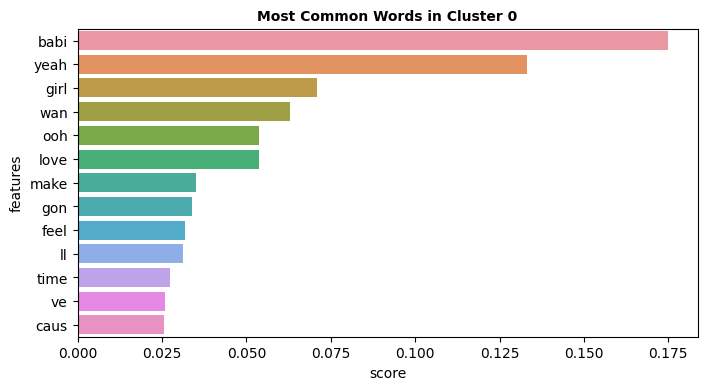

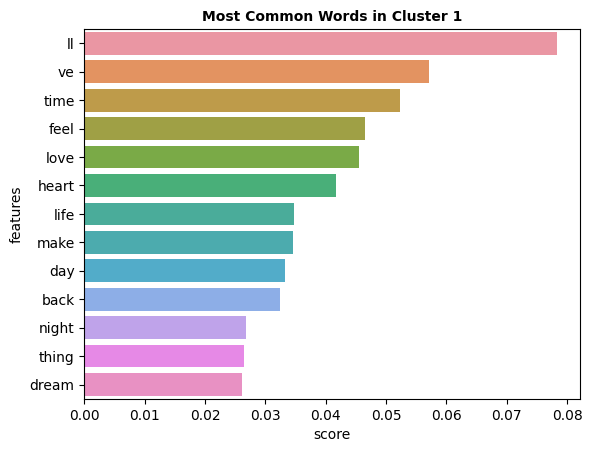

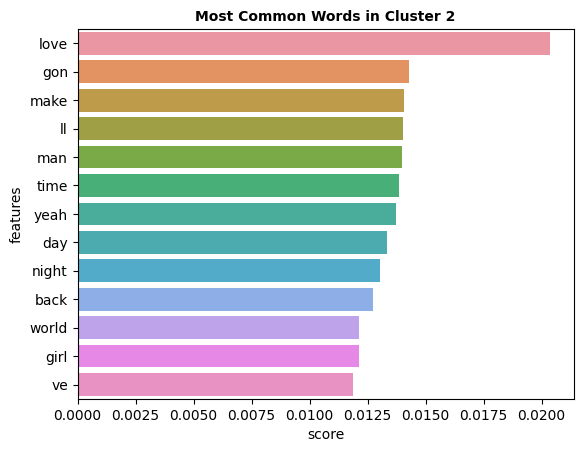

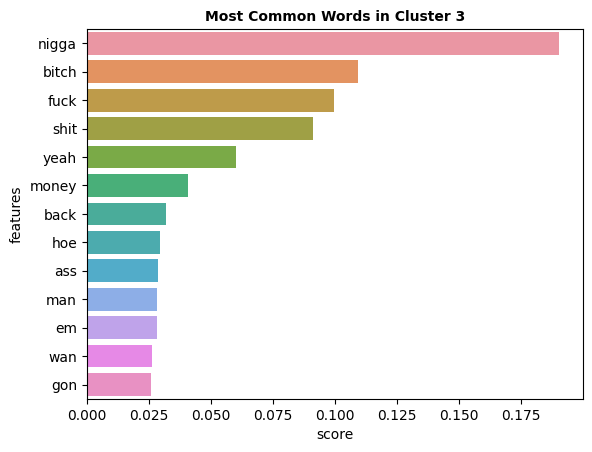

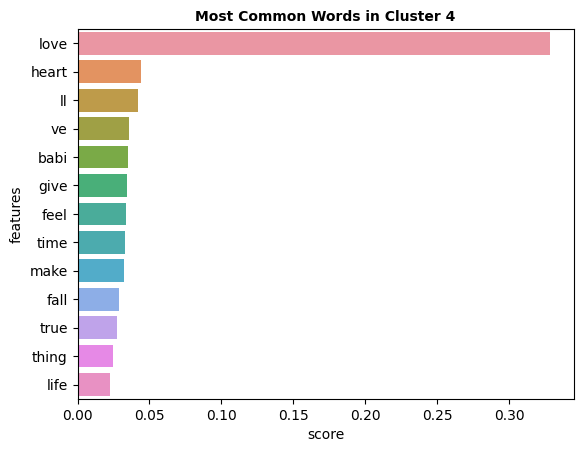

In [16]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

#### Map of Words

Now that we can look at the graphs above and see the best scored words in each cluster, it's also interesting to make it prettier by making a map of words of each cluster!

In [17]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

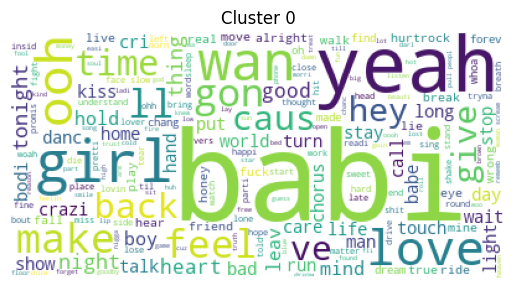

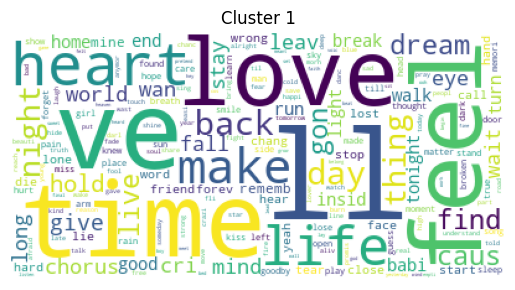

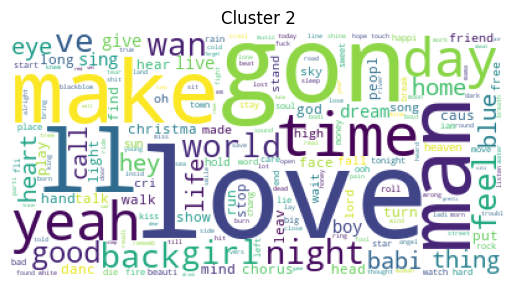

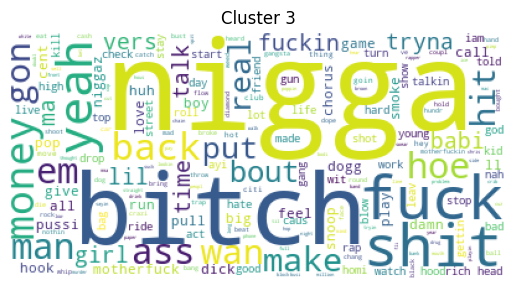

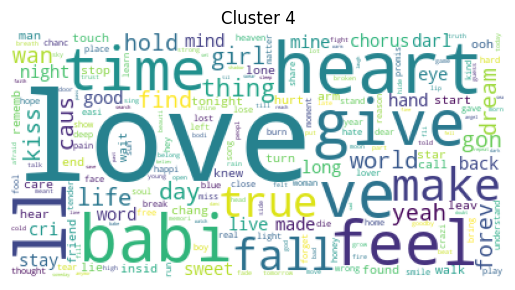

In [18]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

### Preparing our final groups for visualization

Now that we're satisfied with our clustering we should assign which country belongs to which group.

In [ ]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
data['label'] = labels
data.head()

### Visualization the Clustered Countries in a Map

Now that we have our final grouping it would be really cool to visualize it in a interactive map. To do this we'll use the awesome Folium library to see our interactive map!

We'll load a geojson file of polygons and country codes with geopandas and merge it with the labelled dataframe from the cell above.

In [ ]:
# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = 'datasets/world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

data_to_plot.head(3)

Now we'll create a color_step for each group

In [ ]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['r', 'y','g','b', 'm'], vmin=values.min(), vmax=values.max(), caption='step')

color_step

### Painting the Groups into a Choropleth Map

Now that we have all the information that we want to plot into a Dataframe, we'll create a function that makes a Choropleth Map to be displayed on a folium map.

In [ ]:
import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig

In [ ]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)
m